# Testing the signal quality with Alphalens

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import seaborn as sns

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
sns.set_style('whitegrid')

In [4]:
idx = pd.IndexSlice

In [5]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Evaluating the Cross-Validation Results

In [6]:
lookahead = 1

In [7]:
cv_store = Path(results_path / 'parameter_tuning.h5')

### Get AlphaLens Input

In [8]:
DATA_DIR = Path('..', 'data')

Using next available prices.

In [9]:
def get_trade_prices(tickers):
    store = DATA_DIR / 'assets.h5'
    prices = pd.read_hdf(store, 'stooq/jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

Reloading predictions.

In [10]:
best_predictions = pd.read_hdf(results_path / 'predictions.h5', f'test/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2019-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  474264 non-null  float64
 1   0       474264 non-null  float64
 2   1       474264 non-null  float64
 3   2       474264 non-null  float64
 4   3       474264 non-null  float64
 5   4       474264 non-null  float64
 6   5       474264 non-null  float64
 7   6       474264 non-null  float64
 8   7       474264 non-null  float64
 9   8       474264 non-null  float64
 10  9       474264 non-null  float64
dtypes: float64(11)
memory usage: 41.7+ MB


In [11]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()

In [12]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB


In [13]:
factor = (best_predictions
          .iloc[:, :3]
          .mean(1)
          .tz_localize('UTC', level='date')
          .swaplevel()
          .dropna()
          .reset_index()
          .drop_duplicates()
          .set_index(['date', 'ticker']))

In [14]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.091176,0.008467,-0.008580,0.007442,91287,20.085016
2,-0.028925,0.010390,-0.003716,0.005394,90804,19.978746
3,-0.025012,0.014643,-0.001439,0.005304,90804,19.978746
4,-0.022314,0.017857,0.000872,0.005353,90804,19.978746
5,-0.019701,0.116272,0.006104,0.007594,90804,19.978746


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,49.124,1.103,0.438,0.187
beta,-0.025,-0.034,-0.021,-0.010
Mean Period Wise Return Top Quantile (bps),149.785,28.276,13.683,6.365
Mean Period Wise Return Bottom Quantile (bps),-145.333,-28.108,-13.826,-6.570
Mean Period Wise Spread (bps),295.118,56.390,27.515,12.940


Information Analysis


,1D,5D,10D,21D
IC Mean,0.662,0.276,0.192,0.130
IC Std.,0.092,0.117,0.120,0.118
Risk-Adjusted IC,7.160,2.350,1.606,1.102
t-stat(IC),157.363,51.640,35.296,24.225
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-1.413,-0.210,-0.175,-0.250
IC Kurtosis,5.265,0.610,0.517,0.684


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.767,0.788,0.792,0.785
Quantile 2 Mean Turnover,0.788,0.796,0.798,0.793
Quantile 3 Mean Turnover,0.780,0.788,0.793,0.791
Quantile 4 Mean Turnover,0.790,0.793,0.798,0.797
Quantile 5 Mean Turnover,0.772,0.788,0.790,0.785


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.005,-0.01,-0.013,0.005


<Figure size 432x288 with 0 Axes>

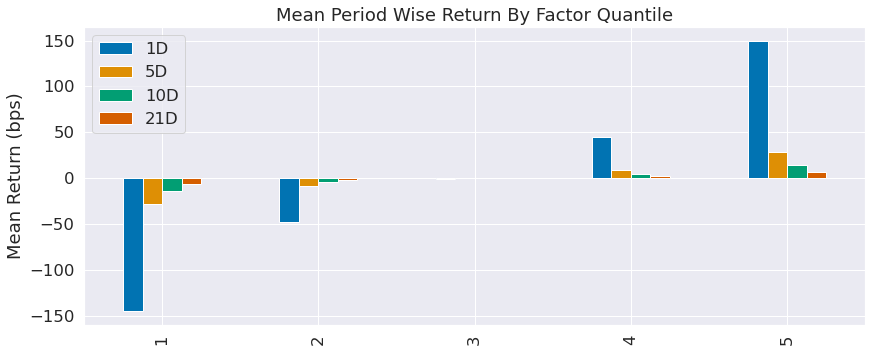

In [15]:
create_summary_tear_sheet(factor_data)

## Evaluating the Out-of-sample predictions

### Prepare Factor Data

In [16]:
t = 1
predictions = pd.read_hdf(results_path / 'predictions.h5',
                          f'test/{t:02}').drop('y_test', axis=1)

In [17]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2019-11-29 00:00:00')) to ('9990.JP', Timestamp('2018-01-05 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       474264 non-null  float64
 1   1       474264 non-null  float64
 2   2       474264 non-null  float64
 3   3       474264 non-null  float64
 4   4       474264 non-null  float64
 5   5       474264 non-null  float64
 6   6       474264 non-null  float64
 7   7       474264 non-null  float64
 8   8       474264 non-null  float64
 9   9       474264 non-null  float64
dtypes: float64(10)
memory usage: 38.1+ MB


In [18]:
factor = (predictions.iloc[:, :10]
                   .mean(1)
                   .sort_index().tz_localize('UTC', level='date').swaplevel().dropna())
factor.head()

date                       ticker 
2017-12-05 00:00:00+00:00  1332.JP    0.000374
2017-12-06 00:00:00+00:00  1332.JP    0.003322
2017-12-07 00:00:00+00:00  1332.JP    0.000753
2017-12-08 00:00:00+00:00  1332.JP    0.000771
2017-12-11 00:00:00+00:00  1332.JP    0.003113
dtype: float64

### Select next available trade prices

Using next available prices.

In [19]:
tickers = factor.index.get_level_values('ticker').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 941 entries, 1332.JP to 9990.JP
dtypes: float64(941)
memory usage: 10.5 MB


### Get AlphaLens Inputs

In [20]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 4.2% entries from factor data: 4.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 454503 entries, (Timestamp('2017-12-05 00:00:00+0000', tz='UTC', freq='C'), '1332.JP') to (Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='C'), '9990.JP')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               454503 non-null  float64
 1   5D               454503 non-null  float64
 2   10D              454503 non-null  float64
 3   21D              454503 non-null  float64
 4   factor           454503 non-null  float64
 5   factor_quantile  454503 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 22.6+ MB


### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.029771,0.011669,-0.003807,0.005517,91290,20.085676
2,-0.026874,0.011995,-0.002648,0.005337,90826,19.983586
3,-0.026736,0.019500,-0.001916,0.005400,90781,19.973686
4,-0.026604,0.020725,-0.001161,0.005487,90803,19.978526
5,-0.026292,0.024385,0.000151,0.005752,90803,19.978526


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.050,0.006,0.003,0.017
beta,0.022,0.021,0.016,0.017
Mean Period Wise Return Top Quantile (bps),2.873,0.712,0.323,0.962
Mean Period Wise Return Bottom Quantile (bps),-1.820,-0.054,-0.516,-1.006
Mean Period Wise Spread (bps),4.694,0.765,0.842,1.969


Information Analysis


,1D,5D,10D,21D
IC Mean,0.010,0.003,0.004,0.017
IC Std.,0.109,0.112,0.109,0.106
Risk-Adjusted IC,0.088,0.027,0.041,0.159
t-stat(IC),1.925,0.588,0.903,3.495
p-value(IC),0.055,0.557,0.367,0.001
IC Skew,-0.007,0.162,0.183,0.342
IC Kurtosis,0.975,0.841,0.810,0.647


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.712,0.743,0.779,0.797
Quantile 2 Mean Turnover,0.777,0.784,0.792,0.800
Quantile 3 Mean Turnover,0.778,0.787,0.792,0.799
Quantile 4 Mean Turnover,0.774,0.785,0.795,0.800
Quantile 5 Mean Turnover,0.706,0.735,0.777,0.799


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.155,0.111,0.033,-0.006


<Figure size 432x288 with 0 Axes>

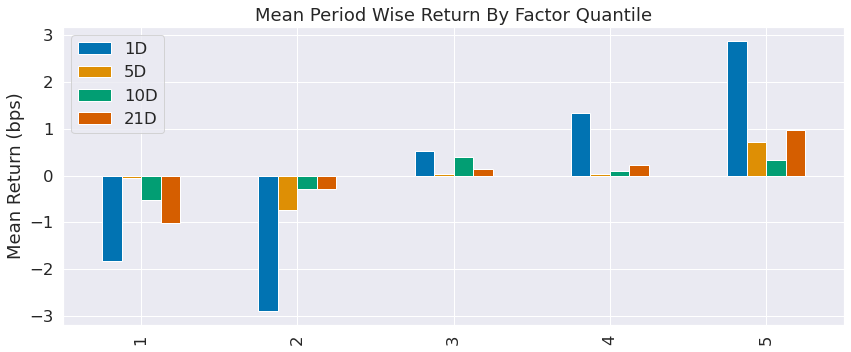

In [21]:
create_summary_tear_sheet(factor_data)